In [1524]:
from urllib.request import urlopen
import pandas as pd
import numpy as np
import pdfplumber
import requests
import warnings
import time

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download("stopwords")
# nltk.download("wordnet")

from bs4 import BeautifulSoup

import difflib

from io import BytesIO

import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [876]:
figures_path = "/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Figures/"

### Create Functions for Legislation Scraping

In [1393]:
def get_all_text(wd, name):
    """
    Function to extract all text from a PDF document of bills taken from 
    https://www.ncsl.org/environment-and-natural-resources/environment-and-natural-resources-state-bill-tracking-database-archive

    Inputs:
    - wd (str): working directory location
    - name (str): document name

    Output: 
    - alltext (str): all text from the PDF
    """
    full_pdf_loc = "/" + wd + "/" + name
    pdf = pdfplumber.open(full_pdf_loc)

    all_text = ""
    page_count = 0

    for p in pdf.pages: 
        if page_count % 50 == 0: 
            print(f"Extracting Page {p.page_number}")
            
        text = p.extract_text()
        
        #elements to clean out of page
        footer = re.search(r"about:(.*) \d*/\d*", text).group()
        
        if p.page_number == 1:
            header_1 = re.search(r"\d/\d{1,2}/\d{1,2}, \d{1,2}:\d{1,2} [A-Z]{2} (.*)(?=Total Bills: \d{3,4})", text, re.DOTALL).group(1)
            header_2 = re.search(r"Total Bills: \d*\n", text).group()
            search_res = None
            text = text.replace(header_2, "")
        else:
            header_1 = re.search(r"\d/\d{1,2}/\d{1,2}, \d{1,2}:\d{1,2} [A-Z]{2}", text).group()
            search_res = re.search(r"Search Results", text, re.DOTALL).group()
            text = text.replace(search_res, "")
        
        text = text.replace(header_1, "")
        text = text.replace(footer, "")
    
        page_count += 1
        all_text = all_text + text

    return all_text

    

In [1394]:
def create_bill_df(all_text):
    """
    Create dataframe using regex to extract text information from the given bill documents

    Inputs: 
    - all_text (str): string from bill PDF, can be extracted using get_all_text()

    Outputs:
    - final_df (pd df): dataframe of all bills from the given document
    """
    #collect dataframe for each bill for later concatenation
    df_list = []
    
    #split all bills in text up
    #t = re.findall(r"([A-Z]+ \d+)", all_text, re.DOTALL)
    bill_pattern = re.compile(r'(?m)^(?:([A-Z]{1,2}(?: \w+)? \d+))\n(.*?)(?=\n[A-Z]{1,2}(?: \w+)? \d+\n|\Z)', re.DOTALL)

        
    bills = []
    for match in bill_pattern.finditer(all_text):
        bill_number = match.group(1)
        bill_text = match.group(2).strip()
        bills.append([bill_number, bill_text])
    
    # #create list of split text for easy iteration
    # split_list = [split_text[i:i + 2] for i in range(0, len(split_text), 2)]
    count = 0
    
    #iterate through bills in list
    for bill in bills:
        bill_dict = {"bill_num" : [],
                "year" : [],
                "description" : [],
                "status" : [],
                "status_location" : [],
                "author" : [],
                "author_affil" : [],
                "addtl_authors_flag" : [],
                "topics" : [], 
                "summary" : [], 
                "intro_date" : [],
                "lastaction_date" : [],
                "lastaction" : [],
                "associated" : []}
        
        bill_num = bill[0]
        print("On bill: ", bill_num)
        
        bill_dict["bill_num"].append(bill_num)
            
        bill_info_raw = bill[1]
        #print(bill_info_raw)

        # if bill_num == "FL H 5001":
        #     print(bill_info_raw)
    
        #extract info about bill
        bill_date = re.search(r"\d\d\d\d", bill_info_raw).group()
        bill_dict["year"].append(bill_date)
        
        bill_description = re.search(r"(?<=\d{4}\n)(.*)(?=\nStatus)", bill_info_raw, re.DOTALL).group()
        bill_dict["description"].append(bill_description)
    
        status_full = re.search(r"Status: (.*)", bill_info_raw).group()
        status_strip = status_full.replace("Status: ", "")
        
        if status_strip == "-":
            status = "NA"
            status_location = "NA"
        elif status_strip == "- Executive Order":
            status = "Executive Order"
            status_location = "NA"
        else:
            status = re.search(r"(.+?)(?= -)", status_strip)
            if status is not None:
                status = status.group()
                status_location = re.search(r"(?<= - )(.*)", status_strip)
                if status_location is not None:
                    status_location = status_location.group()
                else:
                    status_location = "NA"
            else:
                status = "NA"
                status_location = "NA"
        
        bill_dict["status"].append(status)
        bill_dict["status_location"].append(status_location)
        
        date_last_action = re.search(r"Date of Last Action: (.*)", bill_info_raw).group()
        date_last_action = date_last_action.replace("Date of Last Action: ", "")

        if "-" in date_last_action:
            la_date = re.search(r".*(?= - )", date_last_action)
            la_action = re.search(r"(?<= - ).*", date_last_action)

            if la_date:
                la_date = la_date.group()
                la_action = la_action.group()

                bill_dict["lastaction_date"].append(la_date)
                bill_dict["lastaction"].append(la_action)
            else:
                bill_dict["lastaction_date"].append(date_last_action)
                bill_dict["lastaction"].append("NA")
        else:
            bill_dict["lastaction_date"].append(date_last_action)
            bill_dict["lastaction"].append("NA")
        
        
    
        if "Additional Authors" in bill_info_raw:
           
            
            #author = re.search(r"Author: .* \((D|R|DFL)\)(?= Additional)", bill_info_raw)

            author = re.search(r"Author: .*(?= Additional)", bill_info_raw, re.DOTALL)
            addtl_authors = re.search(r"Additional Authors: (.*) \((D|R|DFL|I|P)\)", bill_info_raw, re.DOTALL)
            
            if addtl_authors:
                bill_dict["addtl_authors_flag"].append(1)
                addtl_authors = addtl_authors.group()
           
                addtl_authors_text = addtl_authors.replace("\n", "")
                
                addtl_authors_pattern = r"(\w+)\s*\((\w)\)"
                addtl_authors_list = re.findall(addtl_authors_pattern, addtl_authors_text)
                #print(addtl_authors_list)
                for i, addtl_auth in enumerate(addtl_authors_list):
                    col_auth_name = "addtl_author_" + str(i)
                    col_auth_affil = "addtl_author_affil_" + str(i)
                    
                    addtl_auth_name, addtl_auth_affil = addtl_auth
        
                    bill_dict[col_auth_name] = [addtl_auth_name]
                    bill_dict[col_auth_affil] = [addtl_auth_affil]
            else:
                author = re.search(r"Author: (.*)(?=\nTopics)", bill_info_raw, re.DOTALL)
                bill_dict["addtl_authors_flag"].append(0)
                
        else:
            #author = re.search(r"Author: .* \((D|R|DFL)\)", bill_info_raw)
            author = re.search(r"Author: (.*)(?=\nTopics)", bill_info_raw, re.DOTALL)
            bill_dict["addtl_authors_flag"].append(0)

        #print(author)
        
        if (author is not None) or (author == ""):
            author = author.group()
            author = author.replace("Author: ", "")

            author_name = re.search(r"(.*)(?= \()", author)

            if author_name is not None:
                author_name = author_name.group()
            else:
                author_name = author
            
            author_affil = re.findall(r"\((D|R|DFL|I|P)\)", author)
            if len(author_affil) != 0:
                author_affil = author_affil[0]
            else:
                 author_affil = "NA"
                
        else:
            author_name = "NA"
            author_affil = "NA"
            
        
        #print(author_name)
       
        #print(author_affil)
    
        bill_dict["author"].append(author_name)
        bill_dict["author_affil"].append(author_affil)
        
    
        associated_bills = re.search(r"(?<=Associated Bills: )[^-]+", bill_info_raw)
    
        #associated_bills = re.search(r"Associated Bills: (.*)(?= - Companion)", bill_info_raw)
        topics = re.search(r"(?<=Topics: ).*?(?=\n|$)", bill_info_raw, re.DOTALL)
        
        if associated_bills is not None: 
            associated_bills = associated_bills.group()
            #topics = re.search(r"Topics: (.*)(?=\nAssociated Bills:)", bill_info_raw, re.DOTALL)
            #print(topics)
        else:
            associated_bills = "NA"
            #topics = re.search(r"Topics: (.*)(?=\nSummary)", bill_info_raw, re.DOTALL)
            
        if topics is not None:
            topics = topics.group()
        else:
            topics = "NA"
        topics = topics.replace("\n", " ")
        topics = topics.replace("Topics: ", "")
        bill_dict["topics"].append(topics)

        bill_dict["associated"] = associated_bills
    
        #print(topics)
    
        summary = re.search(r"Summary: (.*)(?=\nHistory)", bill_info_raw, re.DOTALL).group()
        summary = summary.replace("\n", " ")
        summary = summary.replace("Summary: ", "")
        bill_dict["summary"].append(summary)
    
        history = re.search(r"(?<=History: Click for History)(.*)", bill_info_raw, re.DOTALL).group()
        #print(history)
        history_events = re.findall(r"(\d{2}/\d{2}/\d{4}) - (.+?)(?=\n\d{2}/\d{2}/\d{4} -|\Z)", history, re.DOTALL)
    
        for i, _ in enumerate(history_events):
            if i == 0:
                date_intro, _event_intro = history_events[0]
                bill_dict["intro_date"].append(date_intro)     
            else:
                date_ev, event = history_events[i]
                if "\n" in event:
                    event = event.replace("\n", "")
                    
                date_name = "hist" + str(i) + "_date"
                event_name = "hist" + str(i) + "_event"
    
                bill_dict[date_name] = [date_ev]
                bill_dict[event_name] = [event]
    
        if len(bill_dict["intro_date"]) == 0:
            bill_dict["intro_date"] = "NA"
        
        #print(bill_dict)
        bill_df =  pd.DataFrame(bill_dict) 
        
        df_list.append(bill_df) 
    
        # for key in bill_dict:
        #     print(key)
        #     print(len(bill_dict[key]))
        
        #print(bill_df)
        count += 1
    
        # if count == 50:
        #    break

    print("Number of Bills", count)
    final_df = pd.concat(df_list, ignore_index = True, sort = False)

    return final_df

    

### Get Environmental Legislation Text + Clean Resulting Dataframe

In [36]:
%%time
#get environmental bills text
years = list(range(2008, 2025))

text_storage = {}
bill_dict = {}

for year in years:
    print("Working on", year)
    filename = "searchresults" + str(year) + ".pdf"
    bill_text = get_all_text("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/SearchResults", filename)

    text_storage[year] = bill_text

    billdf = create_bill_df(bill_text)

    bill_dict[year] = billdf
    print()

Working on 2008
Extracting Page 1
Extracting Page 51
On bill:  CA S 220
On bill:  CA S 258
On bill:  CA S 399
On bill:  CA A 564
On bill:  CA A 662
On bill:  CA A 946
On bill:  CA A 1521
On bill:  CA A 1560
On bill:  CA A 2030
On bill:  CA A 2112
On bill:  CA A 2153
On bill:  CA A 2404
On bill:  CA A 2425
On bill:  CA A 2993
On bill:  FL H 37
On bill:  GA EO 284
On bill:  MD H 214
On bill:  MA S 145
On bill:  NH H 130
On bill:  NJ SR 30
On bill:  NJ AR 66
On bill:  NJ A 121
On bill:  NJ A 473
On bill:  NJ A 478
On bill:  NJ A 482
On bill:  NJ A 483
On bill:  NJ A 484
On bill:  NJ A 485
On bill:  NJ A 486
On bill:  NJ A 496
On bill:  NJ A 502
On bill:  NJ S 557
On bill:  NJ S 712
On bill:  NJ S 796
On bill:  NJ A 817
On bill:  NJ A 947
On bill:  NJ S 994
On bill:  NJ S 1079
On bill:  NJ A 1111
On bill:  NJ S 1166
On bill:  NJ A 1185
On bill:  NJ A 1326
On bill:  NJ A 1395
On bill:  NJ S 1421
On bill:  NJ S 1454
On bill:  NJ A 1458
On bill:  NJ A 1482
On bill:  NJ A 1613
On bill:  NJ A 1

In [37]:
for year in bill_dict:
    df = bill_dict[year]

    filepath = "/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/BillResults" + "/all_bills" + str(year) + ".csv"

    df.to_csv(filepath, index = False)

In [38]:
#warnings. filterwarnings('ignore') 
years = list(range(2008, 2025))
bill_dict = {}
for year in years:
    filepath = "/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/BillResults" + "/all_bills" + str(year) + ".csv"

    df = pd.read_csv(filepath)

    bill_dict[year] = df

In [39]:
allbills = pd.concat(bill_dict)
#allbills.drop(["Unnamed: 0"], inplace = True)
allbillspath = "/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/BillResults" + "/bills_allyears.csv"
allbills.to_csv(allbillspath)

In [852]:
len(allbills)

27119

In [53]:
#create states column
allbills = allbills.assign(state=allbills['bill_num'].str[:2])

In [926]:
allbills.columns

Index(['bill_num', 'year', 'description', 'status', 'status_location',
       'author', 'author_affil', 'addtl_authors_flag', 'topics', 'summary',
       ...
       'hist1332_event', 'addtl_author_81', 'addtl_author_affil_81',
       'addtl_author_82', 'addtl_author_affil_82', 'addtl_author_83',
       'addtl_author_affil_83', 'addtl_author_84', 'addtl_author_affil_84',
       'state'],
      dtype='object', length=2849)

In [918]:
pd.unique(allbills["status"])

array(['Enacted', 'Failed', 'Vetoed', 'Executive Order', 'Pending',
       'To Governor', 'Adopted', 'To Congress', nan, 'Override Pending',
       'To Mayor'], dtype=object)

In [1496]:
allbills

bill_num  year                                        description  \
2008 0     CA S 220  2008                                       Vended Water   
     1     CA S 258  2008                                     Water Use Fees   
     2     CA S 399  2008  Sacramento-San Joaquin Delta: Water Infrastruc...   
     3     CA A 564  2008    Los Angeles County Flood Control District: Fees   
     4     CA A 662  2008                                 Water Conservation   
...             ...   ...                                                ...   
2024 3289   WY S 66  2024                          Water Exchange Amendments   
     3290   WY H 67  2024          Outdoor Recreation and Tourism Trust Fund   
     3291   WY S 75  2024                         Water Development Projects   
     3292  WY S 103  2024                                  Wyoming PRIME Act   
     3293  WY H 104  2024                        Omnibus Water Bill Planning   

            status                                    status_location  \
2008 0     Enacted                                        Act No. 575   
     1      Failed  Adjourned - Assembly Water, Parks and Wildlife...   
     2      Failed                                             SENATE   
     3      Failed                   Adjourned - Senate Inactive File   
     4     Enacted                                        Act No. 531   
...            ...                                                ...   
2024 3289  Enacted                                         Act No. 49   
     3290  Enacted                                         Act No. 42   
     3291  Enacted                                         Act No. 99   
     3292   Vetoed                                 Vetoed by Governor   
     3293  Enacted                                         Act No. 98   

                        author author_affil  addtl_authors_flag  \
2008 0                 Corbett            D                   1   
     1                 Ducheny            D                   0   
     2                  Dutton            R                   0   
     3                Brownley            D                   0   
     4                  Ruskin            D                   0   
...                        ...          ...                 ...   
2024 3289  Joint Interim Water          NaN                   0   
     3290              Newsome            R                   1   
     3291  Joint Interim Water          NaN                   0   
     3292              Salazar            R                   1   
     3293  Joint Interim Water          NaN                   0   

                                                      topics  \
2008 0                         Water-Conservation/Efficiency   
     1                         Water-Conservation/Efficiency   
     2                         Water-Conservation/Efficiency   
     3                         Water-Conservation/Efficiency   
     4                         Water-Conservation/Efficiency   
...                                                      ...   
2024 3289               Water Allocation and Supply Planning   
     3290                                 Outdoor Recreation   
     3291  Water Allocation and Supply Planning, Water In...   
     3292                                        Food Safety   
     3293                               Water Infrastructure   

                                                     summary  ...  \
2008 0     Transfers requirements of existing law that pr...  ...   
     1     Requires the State Water Resources Control Boa...  ...   
     2     Makes legislative findings and declarations re...  ...   
     3     Authorizes the Los Angeles County Flood Contro...  ...   
     4     Provides that the standards for minimum levels...  ...   
...                                                      ...  ...   
2024 3289  Relates to water, clarifies that water rights ...  ...   
     3290  Relates to State lands, provides for

In [1027]:
year_status = allbills.groupby(["year", "state", "status"]).agg({"status" : "count"})
year_status = pd.DataFrame(year_status)
year_status = year_status.rename(columns={year_status.columns[0]: "numbills"})
year_status

numbills
year state status                   
2008 CA    Enacted                 5
           Failed                  8
           Vetoed                  1
     FL    Failed                  1
     GA    Executive Order         1
...                              ...
2024 WV    Failed                 30
     WY    Enacted                 5
           Failed                  1
           Pending                 3
           Vetoed                  1

[1860 rows x 1 columns]

In [1028]:
ys = year_status.reset_index()
ys = pd.merge(ys, statesdf, how = "left", left_on = "state", right_on = "abbrev")
ys = ys[~ys["abbrev"].isna()]
ys.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/status_by_state.csv")

In [1040]:
years_grouped = allbills.groupby(["year", "state"]).agg({"state" : "count"})
years_grouped = years_grouped.rename(columns={years_grouped.columns[0]: "numbills_total"})
years_grouped = years_grouped.reset_index()
years_grouped

,year,state,numbills_total
0,2008,CA,14
1,2008,FL,1
2,2008,GA,1
3,2008,MA,1
4,2008,MD,1
...,...,...,...
795,2024,VT,39
796,2024,WA,58
797,2024,WI,44
798,2024,WV,40


In [1044]:
state_trends_data = pd.merge(ys, years_grouped, how = "left", left_on = ["state", "year"], right_on = ["state", "year"])
state_trends_data["perc"] = state_trends_data["numbills"] / state_trends_data["numbills_total"]

In [1061]:
state_trends_data["outcome_tag"] = np.where(state_trends_data["status"].isin(outcome_list), "Outcome Finalized", "Outcome Not Finalized")

In [1066]:
outcome_grouped = state_trends_data.groupby(["year", "state", "outcome_tag"]).agg({"numbills" : "count"}).reset_index()
outcome_grouped = pd.merge(outcome_grouped, statesdf, how = "left", left_on = "state", right_on = "abbrev")
outcome_grouped = pd.merge(outcome_grouped, years_grouped, how = "left", on = ["state", "year"])

,year,state,outcome_tag,numbills,abbrev,name,name_lower,numbills_total
0,2008,CA,Outcome Finalized,3,CA,California,california,14
1,2008,FL,Outcome Finalized,1,FL,Florida,florida,1
2,2008,GA,Outcome Not Finalized,1,GA,Georgia,georgia,1
3,2008,MA,Outcome Not Finalized,1,MA,Massachusetts,massachusetts,1
4,2008,MD,Outcome Finalized,1,MD,Maryland,maryland,1
...,...,...,...,...,...,...,...,...
1043,2024,WI,Outcome Finalized,3,WI,Wisconsin,wisconsin,44
1044,2024,WI,Outcome Not Finalized,1,WI,Wisconsin,wisconsin,44
1045,2024,WV,Outcome Finalized,3,WV,West Virginia,west virginia,40
1046,2024,WY,Outcome Finalized,3,WY,Wyoming,wyoming,10


In [1068]:
outcome_grouped["perc"] = outcome_grouped["numbills"] / outcome_grouped["numbills_total"]
outcome_grouped

,year,state,outcome_tag,numbills,abbrev,name,name_lower,numbills_total,perc
0,2008,CA,Outcome Finalized,3,CA,California,california,14,0.214286
1,2008,FL,Outcome Finalized,1,FL,Florida,florida,1,1.000000
2,2008,GA,Outcome Not Finalized,1,GA,Georgia,georgia,1,1.000000
3,2008,MA,Outcome Not Finalized,1,MA,Massachusetts,massachusetts,1,1.000000
4,2008,MD,Outcome Finalized,1,MD,Maryland,maryland,1,1.000000
...,...,...,...,...,...,...,...,...,...
1043,2024,WI,Outcome Finalized,3,WI,Wisconsin,wisconsin,44,0.068182
1044,2024,WI,Outcome Not Finalized,1,WI,Wisconsin,wisconsin,44,0.022727
1045,2024,WV,Outcome Finalized,3,WV,West Virginia,west virginia,40,0.075000
1046,2024,WY,Outcome Finalized,3,WY,Wyoming,wyoming,10,0.300000


In [1070]:
outcome_finalized = outcome_grouped[outcome_grouped["outcome_tag"] == "Outcome Finalized"]
outcome_finalized
outcome_finalized.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/outcome_finalized.csv")

In [1071]:
outcome_not_finalized = outcome_grouped[outcome_grouped["outcome_tag"] == "Outcome Not Finalized"]
outcome_not_finalized.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/outcome_not_finalized.csv")

In [1498]:
state_sum = abdf.groupby(["state"]).agg({"status" : "count"})
state_sum = pd.DataFrame(state_sum)
state_sum = state_sum.rename(columns={state_sum.columns[0]: "numbills"})
state_sum = state_sum.reset_index()
ss = pd.merge(state_sum, statesdf, how = "left", left_on = "state", right_on = "abbrev")
ss = ss[~ss["abbrev"].isna()]

In [1500]:
ss

,state,numbills,abbrev,name,name_lower
0,AK,99,AK,Alaska,alaska
1,AL,111,AL,Alabama,alabama
2,AR,108,AR,Arkansas,arkansas
3,AZ,521,AZ,Arizona,arizona
4,CA,2183,CA,California,california
5,CO,371,CO,Colorado,colorado
6,CT,407,CT,Connecticut,connecticut
7,DC,54,DC,District of Columbia,district of columbia
8,DE,99,DE,Delaware,delaware
9,FL,537,FL,Florida,florida


In [1348]:
#data_avail = pd.read_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/data_avai_0425.csv")
data_avail = pd.read_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/data_avail_0427.csv")
data_avail.columns

Index(['bill_num', 'year', 'status_location', 'author', 'author_affil',
       'addtl_authors_flag', 'topics', 'summary', 'intro_date',
       'lastaction_date',
       ...
       'progress_24_date', 'progress_24_event', 'description', 'status',
       'state', 'state_full', 'ocid_matched', 'vote_id', 'motion_text',
       'organization_id'],
      dtype='object', length=6528)

In [1349]:
dagg = data_avail.groupby(["state"]).agg({"status" : "count"})
dstate_sum = pd.DataFrame(dagg)
dstate_sum = dstate_sum.rename(columns={dstate_sum.columns[0]: "numbills"})
dstate_sum = dstate_sum.reset_index()
dss = pd.merge(dstate_sum, statesdf, how = "outer", left_on = "state", right_on = "abbrev")
dss = dss[~dss["abbrev"].isna()]
dss["state"] = np.where(dss["state"].isna(), dss["abbrev"], dss["state"])
dss["numbills"] = np.where(dss["numbills"].isna(), 0, dss["numbills"])
dss.to_csv("post_filter_bills.csv")

In [1350]:
dss

,state,numbills,abbrev,name,name_lower
0,AK,0.0,AK,Alaska,alaska
1,AL,23.0,AL,Alabama,alabama
2,AR,31.0,AR,Arkansas,arkansas
3,AS,0.0,AS,American Samoa,american samoa
4,AZ,285.0,AZ,Arizona,arizona
5,CA,1071.0,CA,California,california
6,CO,183.0,CO,Colorado,colorado
7,CT,359.0,CT,Connecticut,connecticut
8,DC,0.0,DC,District of Columbia,district of columbia
9,DE,5.0,DE,Delaware,delaware


In [1276]:
ss.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/sum_bills_state_NEW_0427.csv")

In [1133]:
#filter dataframe down to acts that have some outcome 
outcome_list = ["Enacted", "Failed", "Vetoed", "Adopted"]
outcome_filtered = allbills[allbills["status"].isin(outcome_list)]

#remove overseas territories
abdf_1 = outcome_filtered[(outcome_filtered["state"] != "GU") & (outcome_filtered["state"] != "VI") & (outcome_filtered["state"] != "H ") & (outcome_filtered["state"] != "S ")]


In [1134]:
print(len(outcome_filtered))
print(len(abdf_1))


16675
16656


In [1135]:
#clean topics
abdf_1["topic_list"] = abdf_1["topics"].str.split(",")

for i, row in abdf_1.iterrows():
    topic_list = row["topic_list"]

    if type(topic_list) == list:
        abdf_1.at[i, "clean_topic_list"] = topic_list
    else:
        abdf_1.at[i, "clean_topic_list"] = []

In [1182]:
topics_manual_coded = pd.read_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/topics_na.csv")
for i, row in topics_manual_coded.iterrows():
    tl = row["new_list"]
    
    ctl = [tl]
    
    topics_manual_coded.at[i, "clean_topic_list"] = ctl

In [1202]:
topics_manual_coded = topics_manual_coded[["bill_num", "year", "clean_topic_list"]]

In [1203]:
abdf = pd.merge(abdf_1, topics_manual_coded, left_on = ["bill_num", "year"], right_on = ["bill_num", "year"], how = "left")

In [1497]:
state_grouped = abdf.groupby(["state"]).agg({"state" : "count"})
state_grouped = state_grouped.rename(columns={state_grouped.columns[0]: "num_bills"})
state_grouped = state_grouped.reset_index()
state_grouped = state_grouped.sort_values(by='num_bills', ascending = False)
print(state_grouped.to_latex(index=False))

\begin{tabular}{lr}
\toprule
state & num_bills \\
\midrule
CA & 2183 \\
HI & 1342 \\
MN & 1015 \\
WA & 695 \\
VA & 664 \\
TX & 542 \\
FL & 537 \\
ME & 522 \\
AZ & 521 \\
MD & 480 \\
OR & 447 \\
CT & 407 \\
CO & 371 \\
IA & 369 \\
OK & 333 \\
VT & 287 \\
NH & 283 \\
UT & 278 \\
NM & 277 \\
IL & 275 \\
RI & 267 \\
TN & 260 \\
MS & 253 \\
WV & 240 \\
NC & 237 \\
MO & 232 \\
MT & 218 \\
LA & 201 \\
GA & 194 \\
WI & 194 \\
NY & 192 \\
PA & 188 \\
IN & 187 \\
KS & 164 \\
NE & 156 \\
SC & 155 \\
NJ & 149 \\
KY & 149 \\
ID & 130 \\
NV & 120 \\
AL & 111 \\
MI & 109 \\
AR & 108 \\
AK & 99 \\
DE & 99 \\
WY & 95 \\
PR & 83 \\
ND & 71 \\
SD & 55 \\
DC & 54 \\
OH & 32 \\
MA & 26 \\
\bottomrule
\end{tabular}



In [1504]:
abdf[~abdf["clean_topic_list_y"].isna()]

,bill_num,year,description,status,status_location,author,author_affil,addtl_authors_flag,topics,summary,...,dummy_120_150,dummy_150_180,dummy_180_210,dummy_210_240,dummy_240_270,dummy_270_300,dummy_300_330,dummy_330_360,dummy_360_390,dummy_390_420
3977,AL S 256,2018,Income Tax Credit\n,Failed,Adjourned - Senate Finance and Taxation Educat...,Ward,R,0,NaN,Provides a credit against the state income tax...,...,0,0,0,0,0,0,0,0,0,0
3978,AL S 268,2018,Motor Vehicles,Failed,Adjourned - SENATE,Allen Ge,R,0,NaN,Relates to the restrictions on the operation o...,...,0,0,0,0,0,0,0,0,0,0
4640,CO S 64,2018,Renewable Energy,Failed,Adjourned - Postponed Indefinitely,Jones,D,1,NaN,Concerns an update to the renewable energy sta...,...,0,0,0,0,0,0,0,0,0,0
4642,CO S 117,2018,Collect Long Term Climate Change Data\n,Failed,Adjourned - Postponed Indefinitely,Donovan,D,1,NaN,Concerns the collection of greenhouse gas emis...,...,0,0,0,0,0,0,0,0,0,0
4643,CO S 167,2018,Location of Underground Facilities,Enacted,Act No. 256,Scott,R,1,NaN,Revises provisions relating to the increased e...,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15244,HI S 2575,2024,Hawaii Seabed Mining Prevention Act,Enacted,Act No. 2024-228,Lee C,D,0,NaN,"Provides that the mining, extraction, and remo...",...,0,0,0,0,0,0,0,0,0,0
15271,HI H 2740,2024,Zero Waste Initiative,Failed,Adjourned - House Energy and Environmental Pro...,Lowen,D,1,NaN,Establishes the state zero waste initiative to...,...,0,0,0,0,0,0,0,0,0,0
15485,KS H 2570,2024,The Employment Security Law,Enacted,Act No. 83,"Commerce, Labor and Economic Development Cmt",NaN,0,NaN,"Defines of benefit year, temporary unemploymen...",...,0,0,0,0,0,0,0,0,0,0
15991,NE L 1036,2024,Issuance of Free Annual Combination Hunting Pe...,Failed,Adjourned - Natural Resources Committee,Vargas,NaN,0,NaN,Provides for issuance of free annual combinati...,...,0,0,0,0,0,0,0,0,0,0


In [1211]:
type(abdf.loc[3968]["clean_topic_list_y"])

float

In [1505]:
for i, row in abdf.iterrows():
    x = row["clean_topic_list_x"]
    y = row["clean_topic_list_y"]
    # print(x)
    # print(type(x))
    # print(type(x))

    if (len(x) == 0) & (type(y) != float):
        abdf.at[i, "clean_topic_list"] = y
    else:
         abdf.at[i, "clean_topic_list"] = x


In [1507]:
topics = abdf[["bill_num", "year", "status", "clean_topic_list"]]
topics_exp = topics.explode('clean_topic_list')

topics_exp["clean_topic_list"] = topics_exp["clean_topic_list"].str.strip()
topics_exp

,bill_num,year,status,clean_topic_list
0,CA S 220,2008,Enacted,Water-Conservation/Efficiency
1,CA S 258,2008,Failed,Water-Conservation/Efficiency
2,CA S 399,2008,Failed,Water-Conservation/Efficiency
3,CA A 564,2008,Failed,Water-Conservation/Efficiency
4,CA A 662,2008,Enacted,Water-Conservation/Efficiency
...,...,...,...,...
16652,WY H 67,2024,Enacted,Outdoor Recreation
16653,WY S 75,2024,Enacted,Water Allocation and Supply Planning
16653,WY S 75,2024,Enacted,Water Infrastructure
16654,WY S 103,2024,Vetoed,Food Safety


In [1508]:
#clean stripped topic text
rel_col = "clean_topic_list"
clean1 = topics_exp[rel_col] == "Waste and Recycling – Plastic"
clean2 = topics_exp[rel_col] == "Water Conservation and Efficiency"
clean3 = topics_exp[rel_col] == "Air Quality (Outdoor)"
clean4 = topics_exp[rel_col] == "Water-"
clean5 = topics_exp[rel_col] == "Water Quality – Bodies of"
clean6 = topics_exp[rel_col] == "Water Quality – Drinking"
clean7 = topics_exp[rel_col] == "Water Quality –"
clean8 = (topics_exp[rel_col] == "Waste and Recycling –") | (topics_exp[rel_col] == "Waste and")
clean9 = topics_exp[rel_col] == ""
clean10 = (topics_exp[rel_col] == "Disaster Mitigation-") |(topics_exp[rel_col] == "Disaster")
clean11 = (topics_exp[rel_col] == "Disaster – High Winds") | (topics_exp[rel_col] == "Disaster–High Wind")
clean12 = topics_exp[rel_col] == "Waste and Recycling – Extended Producer"
clean13 = topics_exp[rel_col] == "Waste and Recycling-Product"

# clean topics
replacement_values = ['Waste and Recycling-Plastic', 'Water-Conservation/Efficiency', 'Air Quality – Outdoor', "Water", 
                      "Water Quality – Bodies of Water", "Water Quality – Drinking Water", "Water Quality", "Waste and Recycling", "NA", 
                     "Disaster Mitigation", "Disaster – High Wind", "Waste and Recycling – Extended Producer Responsibility", 
                     "Waste and Recycling-Product Stewardship"]

topics_exp[rel_col] = np.select([clean1, clean2, clean3, clean4, clean5, clean6, clean7, clean8, clean9, 
                                      clean10, clean11, clean12, clean13], 
                                     replacement_values, default=topics_exp[rel_col])

In [1509]:
clean_topic_text_dict = {"Waste and Recycling – Plastic" : 'Waste and Recycling-Plastic', 
                        "Water Conservation and Efficiency" : 'Water-Conservation/Efficiency',
                        "Air Quality (Outdoor)" : 'Air Quality – Outdoor',
                        "Water-" : "Water",
                        "Water Quality – Bodies of" : "Water Quality – Bodies of Water",
                        "Water Quality – Drinking" : "Water Quality – Drinking Water",
                        "Water Quality –" : "Water Quality",
                        "Waste and Recycling –" : "Waste and Recycling",
                        "Waste and" : "Waste and Recycling",
                        "Disaster Mitigation-" : "Disaster Mitigation",
                        "Disaster" : "Disaster Mitigation",
                        "Disaster – High Winds" :  "Disaster – High Wind",
                        "Disaster–High Wind" :  "Disaster – High Wind",
                        "Waste and Recycling – Extended Producer" : "Waste and Recycling – Extended Producer Responsibility",
                        "Waste and Recycling-Product" : "Waste and Recycling-Product Stewardship"}

In [1510]:
topic_groups = {"Water" : ["Water-Conservation/Efficiency", "Water-Resources/Planning", "Water", "Water Infrastructure",
                          "Water Allocation and Supply Planning", "Water Quality – Drinking Water", "Water Quality – Bodies of Water",
                          "Wastewater", "Water Quality"],
                
               "Waste" : ["Waste and Recycling", "Waste-Nuclear/Radioactive", "Waste and Recycling-Plastic", "Waste and Recycling-Electronic",
                         "Waste and Recycling-Beverage Containers", "Waste and Recycling-Composting", "Waste and Recycling-Product Stewardship",
                          "Waste and Recycling – Extended Producer Responsibility", "Waste and Recycling – Market Development",
                         "Waste and Recycling – Food"],
                
                "Land" : ["Land", "Land-State Parks", "Land-Conservation Easements", "Land-Forests", "Forests"],
                
                "Disaster Mitigation and Resilience" : ["Disaster Mitigation", "Disaster Mitigation-Flooding", "Disaster Mitigation-Wildfire", 
                                            "Disaster Mitigation-Seismic", "'Disaster Mitigation - High Wind",
                                        "Disaster", "Disaster Resilience",],

                "Disaster" : ["Disaster – Heat and Drought", "Disaster – Wildfires", "Disaster – Wildfires", "Disaster – Flooding",
                             "Disaster – Seismic"],
                
                "Wildlife" : ["Wildlife", "Wildlife-Pollinators", "Wildlife-Invasive Species"],
                
                "Pollution" : ["Pollution", "Air Quality (Outdoor)", "Air Quality – Indoor", "Air Quality – Outdoor"],
                
                "Toxics and Chemicals" : ["Toxics and Chemicals", "Toxics and Chemicals – PFAS", "Toxics and Chemicals – Lead", 
                                          "Toxics and Chemicals – Pesticides", "Toxics and Chemicals – Lead"],
                
                "Outdoor Recreation" : ["Outdoor Recreation"],
                
                "Food" : ["Food Safety"],

                "Environmental Cleanup" : ["Environmental Cleanup"],

                "Climate Change" : ["Climate Change"],

                "Infrastructure and Construction" : ["Infrastructure and Construction"], 

                "Public Programs" : ["Public Programs"], 

                "Utilities" : ["Utilities"],

                "Renewable Energy" : ["Renewable Energy"],

                "Emissions" : ["Emissions"],

                
                "NA" : ["NA", np.nan]
               }

In [1511]:
#create function to search through dictionary items (https://stackoverflow.com/questions/67174383/how-to-get-key-from-a-specific-value-in-a-dictionary-containing-list)
def reverse_search_from_dict(dictionary, keyword):
    for key, values in dictionary.items():
        if keyword in values:
            return key

In [1512]:
#assign general topic group to each bill based on first topic
for i, row in abdf.iterrows():
    topic_list = row["clean_topic_list"]

    num_topics = len(topic_list)

    if num_topics != 0:
        pt = topic_list[0]

        if pt in clean_topic_text_dict:
            primary_topic = clean_topic_text_dict[pt]
        else:
            primary_topic = pt
        
        gen_topic = reverse_search_from_dict(topic_groups, primary_topic)
    else:
        gen_topic = np.nan
        
    abdf.at[i, "primary_topic"] = gen_topic
    abdf.at[i, "num_topics"] = num_topics

In [1517]:
#groupby to create summary statistics for topics
topics_grouped = topics_exp.groupby([rel_col])[rel_col].count()
topics_grouped.sort_values(ascending=False)
print(topics_grouped.to_latex())


\begin{tabular}{lr}
\toprule
 & clean_topic_list \\
clean_topic_list &  \\
\midrule
Air Quality – Indoor & 168 \\
Air Quality – Outdoor & 407 \\
Climate Change & 9 \\
Disaster Mitigation & 1233 \\
Disaster Mitigation-Flooding & 934 \\
Disaster Mitigation-High Wind & 36 \\
Disaster Mitigation-Seismic & 78 \\
Disaster Mitigation-Wildfire & 393 \\
Disaster Resilience & 231 \\
Disaster – Flooding & 183 \\
Disaster – Heat and Drought & 52 \\
Disaster – High Wind & 29 \\
Disaster – Seismic & 26 \\
Disaster – Wildfires & 182 \\
Education and Research & 8 \\
Emissions & 17 \\
Environmental Cleanup & 516 \\
Food Safety & 282 \\
Forests & 127 \\
Fossil Fuels & 42 \\
Infrastructure and Construction & 15 \\
Land & 441 \\
Land-Conservation Easements & 82 \\
Land-Forests & 185 \\
Land-State Parks & 203 \\
NA & 5 \\
Other & 32 \\
Outdoor Recreation & 24 \\
Pollution & 3 \\
Public Programs & 6 \\
Renewable Energy & 136 \\
Tax & 30 \\
Toxics and Chemicals & 233 \\
Toxics and Chemicals – Lead & 83 \\
To

In [1514]:
len(topics_grouped)

62

In [1534]:
topics_gen = abdf[["bill_num", "year", "status", "primary_topic"]]
#groupby to create summary statistics for topics
topics_gen = topics_gen.groupby(["primary_topic"])["primary_topic"].count().sort_values(ascending=False)
topics_gen = pd.DataFrame(topics_gen)
print(topics_gen.to_latex())

\begin{tabular}{lr}
\toprule
 & primary_topic \\
primary_topic &  \\
\midrule
Water & 5009 \\
Waste & 3834 \\
Disaster Mitigation and Resilience & 2016 \\
Wildlife & 788 \\
Land & 614 \\
Toxics and Chemicals & 575 \\
Pollution & 563 \\
Environmental Cleanup & 495 \\
Disaster & 398 \\
Food & 281 \\
Renewable Energy & 136 \\
Utilities & 58 \\
Outdoor Recreation & 24 \\
Emissions & 17 \\
Infrastructure and Construction & 15 \\
Climate Change & 9 \\
Public Programs & 6 \\
\bottomrule
\end{tabular}



In [1537]:
topics_gen = topics_gen.rename(columns={topics_gen.columns[0]: "numbills_total"}).reset_index()
topics_gen

,primary_topic,numbills_total
0,Water,5009
1,Waste,3834
2,Disaster Mitigation and Resilience,2016
3,Wildlife,788
4,Land,614
5,Toxics and Chemicals,575
6,Pollution,563
7,Environmental Cleanup,495
8,Disaster,398
9,Food,281


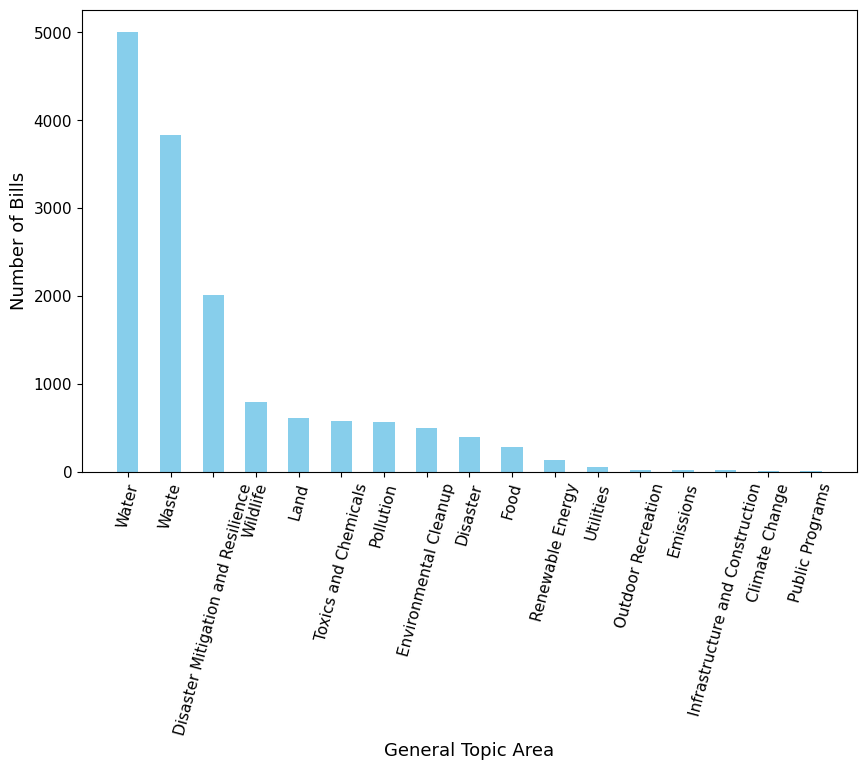

In [1555]:
cat = topics_gen["primary_topic"]
vals = topics_gen["numbills_total"]


plt.figure(figsize=(10,6))
plt.bar(cat, vals, color='skyblue', width=0.5)

#create bar plot with custom aesthetics
# topics_gen.plot(kind='bar', title='Number of Bills by Topic Area',
#                ylabel='Number of Bills', xlabel='General Topic Area', figsize=(10, 6),
#                color = "lightsteelblue", textsize = 20)

#rotate x-axis ticks vertically
plt.xticks(rotation=75)

plt.xlabel('General Topic Area', fontsize = 13)
plt.ylabel('Number of Bills', fontsize = 13)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)


plt.savefig(figures_path + "billscount.jpg", bbox_inches='tight')
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

In [900]:
abdf_states = abdf[["bill_num", "year", "state", "primary_topic"]]
#groupby to create summary statistics for topics
abdf_states = abdf_states.groupby(["state"])["state"].count().sort_values(ascending=False)
abdf_states
print(abdf_states.to_latex())

\begin{tabular}{lr}
\toprule
 & state \\
state &  \\
\midrule
CA & 2183 \\
HI & 1342 \\
MN & 1015 \\
WA & 695 \\
VA & 664 \\
TX & 542 \\
FL & 537 \\
ME & 522 \\
AZ & 521 \\
MD & 480 \\
OR & 447 \\
CT & 407 \\
CO & 371 \\
IA & 369 \\
OK & 333 \\
VT & 287 \\
NH & 283 \\
UT & 278 \\
NM & 277 \\
IL & 275 \\
RI & 267 \\
TN & 260 \\
MS & 253 \\
WV & 240 \\
NC & 237 \\
MO & 232 \\
MT & 218 \\
LA & 201 \\
WI & 194 \\
GA & 194 \\
NY & 192 \\
PA & 188 \\
IN & 187 \\
KS & 164 \\
NE & 156 \\
SC & 155 \\
KY & 149 \\
NJ & 149 \\
ID & 130 \\
NV & 120 \\
AL & 111 \\
MI & 109 \\
AR & 108 \\
AK & 99 \\
DE & 99 \\
WY & 95 \\
PR & 83 \\
ND & 71 \\
SD & 55 \\
DC & 54 \\
OH & 32 \\
MA & 26 \\
H  & 8 \\
S  & 1 \\
\bottomrule
\end{tabular}



In [1258]:
filtered_path = "/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvLegislation/BillResults" 
#abdf.to_csv(filtered_path, index = False)

In [1259]:
abdf.to_json(filtered_path + "/bills_allyears_initFILTERED_0426.json", index = False)

In [1292]:
abdf

,bill_num,year,description,status,status_location,author,author_affil,addtl_authors_flag,topics,summary,...,DisNo_BE,DisDate_BE,ProxFlag_BE,AS_Prox,AS_ProxDays,BE_Prox,BE_ProxDays,close_flag_AS,close_flag_BE,outcome
0,CA S 220,2008,Vended Water,Enacted,Act No. 575,Corbett,D,1,Water-Conservation/Efficiency,Transfers requirements of existing law that pr...,...,2008-0600-USA,2008-01-04,1.0,-329 days,-329.0,83 days,83.0,1,1,1
1,CA S 258,2008,Water Use Fees,Failed,"Adjourned - Assembly Water, Parks and Wildlife...",Ducheny,D,0,Water-Conservation/Efficiency,Requires the State Water Resources Control Boa...,...,2008-0600-USA,2008-01-04,1.0,-324 days,-324.0,193 days,193.0,1,1,0
2,CA S 399,2008,Sacramento-San Joaquin Delta: Water Infrastruc...,Failed,SENATE,Dutton,R,0,Water-Conservation/Efficiency,Makes legislative findings and declarations re...,...,2008-0600-USA,2008-01-04,1.0,-317 days,-317.0,317 days,317.0,1,1,0
3,CA A 564,2008,Los Angeles County Flood Control District: Fees,Failed,Adjourned - Senate Inactive File,Brownley,D,0,Water-Conservation/Efficiency,Authorizes the Los Angeles County Flood Contro...,...,2008-0600-USA,2008-01-04,1.0,-317 days,-317.0,22 days,22.0,1,1,0
4,CA A 662,2008,Water Conservation,Enacted,Act No. 531,Ruskin,D,0,Water-Conservation/Efficiency,Provides that the standards for minimum levels...,...,2008-0600-USA,2008-01-04,1.0,-317 days,-317.0,84 days,84.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16651,WY S 66,2024,Water Exchange Amendments,Enacted,Act No. 49,Joint Interim Water,NaN,0,Water Allocation and Supply Planning,"Relates to water, clarifies that water rights ...",...,2024-0079-USA,2024-02-08,2.0,-14 days,-14.0,-28 days,-28.0,1,1,1
16652,WY H 67,2024,Outdoor Recreation and Tourism Trust Fund,Enacted,Act No. 42,Newsome,R,1,Outdoor Recreation,"Relates to State lands, provides for the admin...",...,2024-0079-USA,2024-02-08,2.0,-17 days,-17.0,-28 days,-28.0,1,1,1
16653,WY S 75,2024,Water Development Projects,Enacted,Act No. 99,Joint Interim Water,NaN,0,"Water Allocation and Supply Planning, Water In...","Relates to water development projects, authori...",...,2024-0079-USA,2024-02-08,2.0,-2 days,-2.0,-41 days,-41.0,1,1,1
16654,WY S 103,2024,Wyoming PRIME Act,Vetoed,Vetoed by Governor,Salazar,R,1,Food Safety,"Relates to marketing homemade goods, provides ...",...,2024-0079-USA,2024-02-08,2.0,-54 days,-54.0,-36 days,-36.0,1,1,0


0                                            182994.0
1                                            183000.0
2                                            183003.0
3                                            183006.0
4                                            183012.0
                            ...                      
5617    ocd-bill/07573c91-b421-4f14-9954-c9e8ef5ce03c
5618    ocd-bill/c228b37a-6bf4-4f6d-9e48-f30818b17761
5619    ocd-bill/70d8c6b4-0c10-4ba7-b4e6-a44a911a7588
5620    ocd-bill/def673ee-da0a-4146-9aae-3d2c73944dae
5621    ocd-bill/2094b156-7063-490d-8022-21b942399861
Name: bill_id, Length: 5622, dtype: object

In [1297]:
dfa = pd.read_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/data_with_cleaned_topic.csv")
dfa["bill_id"]

subsetbills = list(dfa["bill_num"])
abdf["subset_tag"] = np.where(abdf["bill_num"].isin(subsetbills), 1, 0)

In [1300]:
abdf["duration"] = abdf["lastaction_date"] - abdf["intro_date"]

In [1306]:
abdf["duration_days"] = pd.to_numeric(abdf["duration"].dt.days, downcast='integer')

In [1347]:

# Generate some example data
data = np.random.rand(100)

# Define custom bin edges
bin_edges = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Use numpy's histogram function with custom bins
hist, bins = np.histogram(data, bins=bin_edges)


array([19, 15, 19, 25, 22])

In [1342]:
abdf.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/allbills_taggedsubset.csv", index = False)

In [1315]:
topic_list = list(pd.unique(abdf["primary_topic"]))
topic_list

['Water',
 'Waste',
 nan,
 'Land',
 'Environmental Cleanup',
 None,
 'Disaster Mitigation and Resilience',
 'Wildlife',
 'Pollution',
 'Renewable Energy',
 'Emissions',
 'Infrastructure and Construction',
 'Public Programs',
 'Utilities',
 'Toxics and Chemicals',
 'Climate Change',
 'Disaster',
 'Outdoor Recreation',
 'Food']

In [1335]:
for topic in topic_list:
    print(topic)
    topic_df = abdf[abdf["primary_topic"] == topic]
    
    sample_idx = topic_df.sample(frac=0.2).index.tolist()
    
    topic_df["sample_tag"] = np.where(topic_df.index.isin(sample_idx), 1, 0)
    
    
    topic_df.to_csv(f"/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/DataByTopic/{topic}_grouped.csv", index = False)

    time.sleep(2)

Water
Waste
nan
Land
Environmental Cleanup
None
Disaster Mitigation and Resilience
Wildlife
Pollution
Renewable Energy
Emissions
Infrastructure and Construction
Public Programs
Utilities
Toxics and Chemicals
Climate Change
Disaster
Outdoor Recreation
Food


### Cleaning Bill and Environmental DataFrames

In [112]:
import datetime as dt

In [1462]:
envdf = pd.read_excel("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvData/public_emdat_custom_request_2025-05-05_51494ee3-a353-4156-9715-4a7afdc9c16f.xlsx")

In [1463]:
#clean location text in environmental dataframe
envdf["LocClean"] = envdf["Location"].str.replace(r"(", "")
envdf["LocClean"] = envdf["LocClean"].str.replace(r")", "")
envdf["LocationList"] = envdf["LocClean"].apply(lambda x: x.split(","))

In [1464]:
#clean up location of events in environmental data bases to match 
state_dict = {
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#States.
    "AK": "Alaska",
    "AL": "Alabama",
    "AR": "Arkansas",
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "IA": "Iowa",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "MA": "Massachusetts",
    "MD": "Maryland",
    "ME": "Maine",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MO": "Missouri",
    "MS": "Mississippi",
    "MT": "Montana",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "NE": "Nebraska",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NV": "Nevada",
    "NY": "New York",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VA": "Virginia",
    "VT": "Vermont",
    "WA": "Washington",
    "WI": "Wisconsin",
    "WV": "West Virginia",
    "WY": "Wyoming",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Federal_district.
    "DC": "District of Columbia",
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Inhabited_territories.
    "AS": "American Samoa",
    "GU": "Guam GU",
    "MP": "Northern Mariana Islands",
    "PR": "Puerto Rico PR",
    "VI": "U.S. Virgin Islands",
}

newlocs = []
for i, row in envdf.iterrows():
    location = row["LocationList"]
    new_loc_list = []
    for abbrev, name in state_dict.items():
        if name in location:
            new_loc_list.append(abbrev)
        else:
            check = [words for segments in location for words in segments.split()]
            if name in check:
                new_loc_list.append(abbrev)

    newlocs.append(new_loc_list)

envdf["NewLocs"] = newlocs

In [1465]:
state_df = {"abbrev" : [],
           "name" : []}
for key, val in state_dict.items():
    state_df["abbrev"].append(key)
    state_df["name"].append(val)

statesdf = pd.DataFrame(state_df)
statesdf["name_lower"] = statesdf["name"].str.lower()

In [1466]:
#convert date columns into date format
envdf["start_date"] = pd.to_datetime(dict(day = envdf["Start Day"], month = envdf["Start Month"], year = envdf["Start Year"]), errors = "coerce")
envdf["end_date"] = pd.to_datetime(dict(day = envdf["End Day"], month = envdf["End Month"], year = envdf["End Year"]), errors = "coerce")

In [1467]:
envdf.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update', 'LocClean', 'LocationList',
       'NewLocs', 'start_date', 'end_date'],
      dtype='object')

In [1468]:
#filter environmental events DF by key values
envdf = envdf[(~envdf["start_date"].isna()) & (~envdf["end_date"].isna())]
envdf = envdf[envdf["NewLocs"].map(len) != 0]

envdf["start_year"] = envdf['start_date'].dt.year
envdf["end_year"] = envdf['start_date'].dt.year

#create df sorted by environmental events start date
sorted_start = envdf.sort_values(by = "start_date").reset_index(drop = True)

#create df sorted by environmental events end date
sorted_end = envdf.sort_values(by = "end_date").reset_index(drop = True)

envdf.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvData/envdata_for_analysis_0504.csv", index = False)

In [1104]:
disaster_loc = envdf[["start_year", "end_year", "NewLocs"]].explode("NewLocs")
disaster_loc["to_sum"] = 1

In [1105]:
disaster_loc = pd.merge(disaster_loc, statesdf, how = "left", left_on = "NewLocs", right_on = "abbrev")
disaster_loc

,start_year,end_year,NewLocs,to_sum,abbrev,name,name_lower
0,2008,2008,CA,1,CA,California,california
1,2008,2008,NV,1,NV,Nevada,nevada
2,2008,2008,OR,1,OR,Oregon,oregon
3,2008,2008,AL,1,AL,Alabama,alabama
4,2008,2008,AR,1,AR,Arkansas,arkansas
...,...,...,...,...,...,...,...
2054,2024,2024,AR,1,AR,Arkansas,arkansas
2055,2024,2024,MO,1,MO,Missouri,missouri
2056,2024,2024,OK,1,OK,Oklahoma,oklahoma
2057,2024,2024,CA,1,CA,California,california


In [1107]:
disaster_loc_count = disaster_loc.groupby(["abbrev", "name_lower", "start_year"]).agg({"to_sum" : "count"}).reset_index()
disaster_loc_count.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvData/disaster_count_by_year.csv")

In [631]:
#create list of neighboring states for proximity sorting
neighbors = {
    # https://state.1keydata.com/bordering-states-list.php
    "AK": [],
    "AL": ["FL", "GA", "MS", "TN"],
    "AR": ["LA", "MS", "MO", "OK", "TN", "TX"],
    "AZ": ["CA", "CO", "NV", "NM", "UT"],
    "CA": ["AZ", "NV", "CO"],
    "CO": ["AZ", "KS", "NE", "NM", "OK", "UT", "WY"],
    "CT": ["MA", "NY", "RI"],
    "DE": ["MD", "NJ", "PA"],
    "FL": ["AL", "GA"],
    "GA": ["AL", "FL", "NC", "SC", "TN"],
    "HI": [],
    "IA": ["IL", "MN", "MO", "NE", "SD", "WI"],
    "ID": ["MT", "NV", "OR", "UT", "WA", "WY"],
    "IL": ["IN", "IA", "MI", "KY", "MO", "WI"],
    "IN": ["IL", "KY", "MI", "OH"],
    "KS": ["CO", "MO", "NE", "OK"],
    "KY": ["IL", "IN", "MO", "OH", "TN", "VA", "WV"],
    "LA": ["AR", "MS", "TX"],
    "MA": ["CT", "NH", "NY", "RI", "VT"],
    "MD": ["DE", "PA", "VA", "WV"],
    "ME": ["NH"],
    "MI": ["IL", "IN", "MN", "OH", "WI"],
    "MN": ["IA", "MI", "ND", "SD", "WI"],
    "MO": ["AR", "IL", "IA", "KS", "KY", "NE", "OK", "TN"],
    "MS": ["AL", "AK", "LA", "TN"],
    "MT": ["ID", "ND", "SD", "WY"],
    "NC": ["GA", "SC", "TN", "VA"],
    "ND": ["MN", "MT", "SD"],
    "NE": ["CO", "IA", "KS", "MO", "SD", "WY"],
    "NH": ["ME", "MA", "VT"],
    "NJ": ["DE", "NY", "PA"],
    "NM": ["AZ", "CO", "OK", "TX", "UT"],
    "NV": ["AZ", "CA", "ID", "OR", "UT"],
    "NY": ["CT", "MA", "NJ", "PA", "RI", "VT"],
    "OH": ["IN", "KY", "MI", "PA", "WV"],
    "OK": ["AR", "CO", "KS", "MO", "NM", "TX"],
    "OR": ["CA", "ID", "NV", "WA"],
    "PA": ["DE", "MD", "NJ", "NY", "OH", "WV"],
    "RI": ["CT", "MA", "NY"],
    "SC": ["GA", "NC"],
    "SD": ["IA", "MN", "MT", "NE", "ND", "WY"],
    "TN": ["AL", "AR", "GA", "KY", "MS", "MO", "NC", "VA"],
    "TX": ["AR", "LA", "NM", "OK"],
    "UT": ["AZ", "CO", "ID", "NV", "NM", "WY"],
    "VA": ["KY", "MD", "OH", "PA", "VA"],
    "VT": ["MA", "NH", "NY"],
    "WA": ["ID", "OR"],
    "WI": ["IL", "IA", "MI", "MN"],
    "WV": ["KY", "MA", "OH", "PA", "VA"],
    "WY": ["CO", "ID", "MT", "NE", "SD", "UT"],
    # https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States#Federal_district.
    "DC": ["MD", "VA"],
    "PR" : []
}

In [677]:
def classify_and_highlight(summary, pro_keywords, anti_keywords, exclude_keywords):
    """
    
    """
    text = str(summary).lower()
    triggered_pro = []

    for kw in exclude_keywords:
        if kw in text:
            return None, []
        
    for kw in pro_keywords:
        if kw in text:
            triggered_pro.append(kw)

    triggered_anti = []
    for kw in anti_keywords:
        if kw in text:
            triggered_anti.append(kw)

    if len(triggered_anti) > len(triggered_pro):
        return 0, triggered_anti
    if len(triggered_pro) > len(triggered_anti):
        return 1, triggered_pro


    return None, []

In [637]:
def check_elements(list_to_check, df_list):
    """
    Helper function to compare list elements in a dataframe
    """
    return any(item in list_to_check for item in df_list)

In [1385]:
def match_bill_to_event(dataframe, envdf, time_boundary, pro_flag):
    """
    Function to match a structured bill dataframe 
    """

    #set type of new columns to allow later data entry
    dataframe["DisLoc_AS"] = ""
    dataframe["DisLoc_AS"] =  dataframe["DisLoc_AS"].astype("object")
    
    dataframe["DisLoc_BE"] = ""
    dataframe["DisLoc_BE"] = dataframe["DisLoc_BE"].astype("object")

    dataframe["intro_date"] = pd.to_datetime(dataframe["intro_date"], format="%m/%d/%Y", errors = "coerce" )
    dataframe["lastaction_date"] = pd.to_datetime(dataframe["lastaction_date"], format="%m/%d/%Y", errors = "coerce")

    #assign numerical dumy to outcome of bills
    dataframe["status_flag"] = np.where(((dataframe["status"] == "Enacted") | (dataframe["status"] == "Adopted")), 1, 0)
    
    for i, row in dataframe.iterrows():
        bill_name = row["bill_num"]
        print(f"Working on {bill_name}")
        
        state = row["state"]
        #obtain neighboring states from neighboring states dictionary
        neighboring = neighbors[state]
    
        #create copy of neighboring states list to append bill state to
        rel_states = copy.deepcopy(neighbors[state])
        rel_states.append(state)
    
        #get date information to search by
        bill_start = row["intro_date"]
        bill_end = row["lastaction_date"]
    
        
        state_constrained = envdf[envdf["NewLocs"].apply(lambda x: check_elements(rel_states, x))]
    
        if len(state_constrained) != 0: 
            sorted_start = state_constrained.sort_values(by = "start_date").reset_index(drop = True)
            
    
            #find index of closest occuring natural disaster after the start of a bill
            idx_closest_disaster_after_bill_start = sorted_start.start_date.searchsorted(bill_start)
    
            if idx_closest_disaster_after_bill_start >= len(state_constrained): 
                idx_closest_disaster_after_bill_start = len(state_constrained) - 1
            
            aft_start_idx = sorted_start.at[idx_closest_disaster_after_bill_start, "DisNo."]
            aft_start_date = sorted_start.at[idx_closest_disaster_after_bill_start, "start_date"]
            aft_start_locs = sorted_start.at[idx_closest_disaster_after_bill_start, "NewLocs"]
    
            dataframe.at[i, "DisNo_AS"] = aft_start_idx
            dataframe.at[i, "DisDate_AS"] = aft_start_date
            dataframe.at[i, "DisLoc_AS"] = aft_start_locs
    
            #create proximity flags
            if state in aft_start_locs:
                dataframe.at[i, "ProxFlag_AS"] = 1
            elif  check_elements(neighboring, aft_start_locs):
                dataframe.at[i, "ProxFlag_AS"] = 2
        
        
            #find index of closest occuring natural disaster before the end of a bill 
            idx_closest_disaster_before_bill_end = sorted_start.start_date.searchsorted(bill_end)
            
            if idx_closest_disaster_before_bill_end != 0: 
                idx_closest_disaster_before_bill_end = idx_closest_disaster_before_bill_end - 1
    
            
            before_end_idx = sorted_start.at[idx_closest_disaster_before_bill_end, "DisNo."]
            before_end_date = sorted_start.at[idx_closest_disaster_before_bill_end, "start_date"]
            before_end_loc = sorted_start.at[idx_closest_disaster_before_bill_end, "NewLocs"]
    
            dataframe.at[i, "DisNo_BE"] = before_end_idx
            dataframe.at[i, "DisDate_BE"] = before_end_date
            dataframe.at[i, "DisLoc_BE"] = before_end_loc
    
            #create proximity flags
            if state in before_end_loc:
                dataframe.at[i, "ProxFlag_BE"] = 1
            elif  check_elements(neighboring, before_end_loc):
                dataframe.at[i, "ProxFlag_BE"] = 2
            
        else:
            dataframe.at[i, "ProxFlag_AS"] = 0
            dataframe.at[i, "ProxFlag_BE"] = 0

    dataframe["AS_Prox"] = dataframe["intro_date"] - dataframe["DisDate_AS"]
    dataframe["AS_ProxDays"] = pd.to_numeric(dataframe["AS_Prox"].dt.days, downcast='integer')
    dataframe["BE_Prox"] = dataframe["DisDate_BE"] - dataframe["lastaction_date"]
    dataframe["BE_ProxDays"] = pd.to_numeric(dataframe["BE_Prox"].dt.days, downcast='integer')
    
    boundary = dt.timedelta(time_boundary)
    dataframe["close_flag_AS"] = np.where((abs(dataframe["AS_Prox"]) <= boundary), 1, 0)
    dataframe["close_flag_BE"] = np.where((abs(dataframe["BE_Prox"]) <= boundary), 1, 0)

    if pro_flag: 
        dataframe["outcome"] = np.where(((dataframe["status_flag"] == 1) & (dataframe["pro_flag"] == 1)), 1, 0)
    else:
        dataframe["outcome"] = np.where(((dataframe["status_flag"] == 1)), 1, 0)

    return dataframe


In [1449]:
#create new DF to filter and work off of
categorized = abdf.copy(deep = True)

pro_env_keywords = [
    # General
    "increase environmental protection", "natural resource conservation", "habitat preservation",
    "ecological restoration", "increase species protection", "biodiversity", "protect wetlands",
    "environmental remediation", "endangered species", "studying environmental impact",
    "consumer confidence report", "submit report", "standards for minimum levels", 
    "convene working group", "protection council", "improve environmental protection",
    
    # Climate & Emissions
    "reduce emissions", "carbon reduction", "climate action plan", "climate resilience",
    "carbon neutrality", "greenhouse gas reduction", "net-zero emissions", "decarbonization",
    "climate adaptation", "climate change mitigation", "emissions standards", "cap-and-trade",

    # Energy & Efficiency
    "clean energy", "renewable energy", "solar energy", "wind energy", "geothermal",
    "electric vehicles", "charging infrastructure", "energy efficiency", "green building standards",
    "leed certification", "energy conservation", "smart grid", "battery storage",

    # Water & Air
    "clean water", "drinking water standards", "clean air", "air quality improvement",
    "stormwater management", "watershed protection", "water conservation", "wastewater treatment",
    "lead pipe replacement", "pfas regulation", "recycling tax", "recycling", "recycle", 
    "improve",

    # Land & Agriculture
    "sustainable land use", "land conservation", "public lands access", "forest protection",
    "reforestation", "green infrastructure", "urban greening", "sustainable agriculture",

    # Governance
    "environmental justice", "climate task force", "environmental review", "community resilience",
    "carbon pricing", "environmental impact statement", "environmental equity", "meet federal standards", 
    "identify best management practices", "imposes fee", "ban"

    "water conservation", "stormwater management", "conserve water", "water efficiency",
    "bottled water standards", "water source labeling", "consumer confidence report",
    "water infrastructure", "wastewater agency", "clean drinking water", "water use reduction",

    # Energy and Efficiency
    "energy efficiency", "appliance efficiency standards", "reduce energy consumption",
    "water-efficient devices", "energy saving standards", "energy resources conservation",
    "conservation standards", "renewable energy", "clean energy", "solar", "wind",

    # Land use and climate
    "flood control", "green infrastructure", "environmentally preferable", "habitat protection",
    "carbon reduction", "greenhouse gas", "net-zero emissions", "climate resilience",

    # Governance & Reporting
    "environmental impact report", "submit a report to legislature", "environmental justice",
    "environmentally preferable", "energy conservation", "environmental protection", "consider studying"
]



anti_env_keywords = [
    # Fossil Fuels
    "fossil fuel development", "oil and gas production", "permits coal mining", "permits fracking",
    "permits hydraulic fracturing", "increases hydraulic fracturing",
    "permits offshore drilling", "allows offshore drilling", "energy independence", "fossil fuel subsidies",
    "liquefied natural gas", "drilling permits", "expedite exploration", 
    "deregulate environmental standards", "repeal emissions standards", "repeal environmental regulations",
    "regulatory relief", "reduce oversight", "rollback clean air standards", "rollback water protections",
    "weaken environmental laws", "reduce epa authority", "suspend enforcement", "limit agency authority",
    "deregulate", "remove restrictions","reduce regulation", "reduce funding", 

    # Blocking Climate
    "prohibit climate regulations", "ban climate mandates", "prohibit carbon tax", "reject cap-and-trade",
    "delay climate action", "prohibit renewable mandates", "restrict solar development", "restrict wind development",

    # Permitting
    "fast-track permitting", "streamline environmental review", "exempt from environmental review",
    "override local zoning", "eliminate environmental review", "restrict conservation easements",
    "limit wildlife protections", "exemptions", "exempt",

    # Anti-renewables
    "prohibit solar mandates", "restrict wind energy", "barriers to renewables", "limit net metering",
    "anti-electric vehicle policy", "ban ev charging infrastructure"

]

exclude_env_keywords = []

results = categorized['summary'].apply(lambda x: classify_and_highlight(x, pro_env_keywords, anti_env_keywords, exclude_env_keywords))
categorized['pro_flag'] = results.apply(lambda x: x[0])
categorized['trigger_keywords'] = results.apply(lambda x: ", ".join(x[1]) if x[1] else None)
#categorized = categorized[~categorized["pro_flag"].isna()]

print(len(categorized))
print(len(categorized[categorized["pro_flag"] == 0]))



16656
597


In [1475]:
with_vote_info = pd.read_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/final_vote_of_case_only.csv")

In [1480]:
vote_data_cases = list(pd.unique(with_vote_info["bill_num"]))

In [1482]:
categorized["vote_data_present"] = np.where(categorized["bill_num"].isin(vote_data_cases), 1, 0)

In [1486]:
categorized.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/categorizedlegislation_wo_proflag.csv")

In [654]:
%%time
#create dataframe of matched environmental events for analysis
cdf = match_bill_to_event(categorized, envdf, 365, pro_flag = True)
cdf.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/categorized_data_for_analysis_0504.csv")

Working on CA S 220
Working on CA S 399
Working on CA A 564
Working on CA A 662
Working on CA A 946
Working on CA A 1521
Working on CA A 1560
Working on CA A 2030
Working on CA A 2112
Working on CA A 2404
Working on CA A 2993
Working on FL H 37
Working on NJ A 817
Working on NJ A 1185
Working on NJ S 1421
Working on NJ A 1613
Working on NJ A 1639
Working on NJ A 1910
Working on NJ S 2888
Working on NJ S 2889
Working on NJ A 3343
Working on OR S 1069
Working on PA H 1705
Working on VT S 300
Working on VA HJR 112
Working on VA H 343
Working on VA H 344
Working on VA H 795
Working on VA S 930
Working on VA S 971
Working on VA H 1229
Working on VA S 1509
Working on VA H 1533
Working on VA H 1548
Working on VA H 1549
Working on VA H 1925
Working on VA H 1991
Working on VA H 2168
Working on VA H 2177
Working on VA H 2649
Working on AL S 309
Working on AL S 619
Working on AL H 621
Working on AL H 630
Working on AL H 716
Working on AL H 933
Working on AK H 134
Working on AZ S 1362
Working on A

KeyError: 'pro_flag'

In [1360]:
%%time
#create dataframe of matched environmental events for analysis
all_bills_matched = match_bill_to_event(abdf, envdf, 365, pro_flag = False)
all_bills_matched.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/categorized_data_for_analysis_0428.csv")

Working on CA S 220
Working on CA S 258
Working on CA S 399
Working on CA A 564
Working on CA A 662
Working on CA A 946
Working on CA A 1521
Working on CA A 1560
Working on CA A 2030
Working on CA A 2112
Working on CA A 2153
Working on CA A 2404
Working on CA A 2425
Working on CA A 2993
Working on FL H 37
Working on MD H 214
Working on NH H 130
Working on NJ A 817
Working on NJ A 1185
Working on NJ S 1421
Working on NJ A 1613
Working on NJ A 1639
Working on NJ A 1910
Working on NJ A 2287
Working on NJ S 2888
Working on NJ S 2889
Working on NJ A 3343
Working on OR S 1069
Working on PA H 1705
Working on VT S 286
Working on VT S 300
Working on VA SJR 82
Working on VA HJR 112
Working on VA HJR 169
Working on VA H 343
Working on VA H 344
Working on VA S 711
Working on VA H 795
Working on VA S 873
Working on VA S 930
Working on VA S 971
Working on VA S 1187
Working on VA H 1229
Working on VA S 1509
Working on VA S 1523
Working on VA H 1533
Working on VA H 1534
Working on VA H 1548
Working on

In [1410]:
figpath = "/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Figures/"

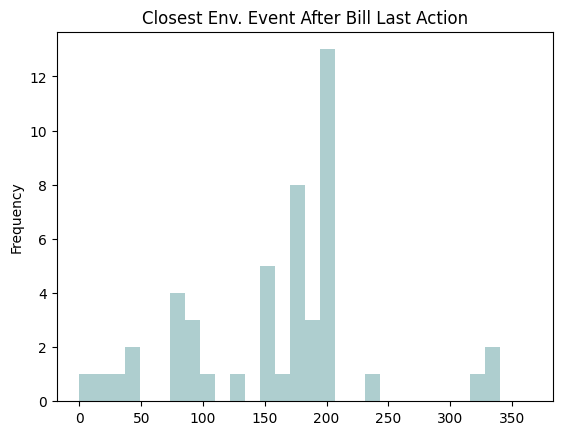

In [1416]:
all_bills_matched.plot.hist(column = ["BE_ProxDays"], bins=30, alpha=0.5, range=[0, 365], color = "cadetblue",
               title='Closest Env. Event After Bill Last Action', legend = False)

plt.savefig(figpath + "env_event_after_bill_LA.jpeg", bbox_inches='tight')
plt.show()

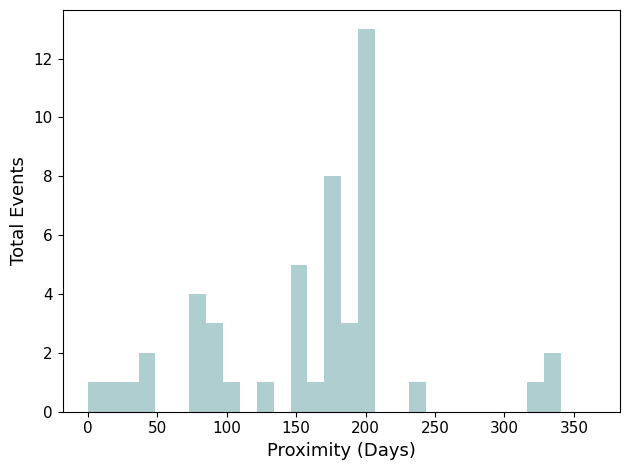

In [1559]:
n_bins = 30

fig, ax = plt.subplots(1, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
ax.hist(all_bills_matched["BE_ProxDays"], bins=n_bins, range=[0, 365], alpha = 0.5,  color = "cadetblue")
plt.xlabel('Proximity (Days)', fontsize = 13)
plt.ylabel('Total Events', fontsize = 13)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig(figpath + "post_LA_days_histo.jpeg", bbox_inches='tight')

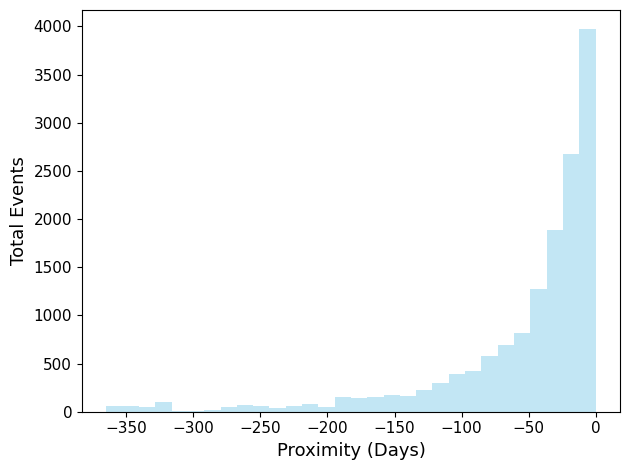

In [1562]:
n_bins = 30

fig, ax = plt.subplots(1, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
ax.hist(all_bills_matched["BE_ProxDays"], bins=n_bins, range=[-365, 0], alpha = 0.5,  color = "skyblue")
plt.xlabel('Proximity (Days)', fontsize = 13)
plt.ylabel('Total Events', fontsize = 13)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig(figpath + "pre_LA_days_histo.jpeg", bbox_inches='tight')

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Admin Units,Entry Date,Last Update,LocClean,LocationList,NewLocs,start_date,end_date,start_year,end_year
0,2008-0010-USA,No,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,USA,...,"[{""adm1_code"":3218,""adm1_name"":""California""},{...",2008-11-19,2023-09-25,"California, Nevada, Oregon provinces","[California, Nevada, Oregon provinces]","[CA, NV, OR]",2008-01-05,2008-01-09,2008,2008
1,2008-0039-USA,No,nat-met-sto-tor,Natural,Meteorological,Storm,Tornado,GLIDE:TO-2008-000020,NaN,USA,...,"[{""adm1_code"":3214,""adm1_name"":""Alabama""},{""ad...",2009-03-18,2023-09-25,"Tennessee, Arkansas, Kentucky, Mississippi, Al...","[Tennessee, Arkansas, Kentucky, Mississippi...","[AL, AR, IL, IN, KY, MO, MS, OH, TN, TX]",2008-02-05,2008-02-06,2008,2008
2,2008-0099-USA,No,nat-geo-ear-gro,Natural,Geophysical,Earthquake,Ground movement,USGS:nn00234425,NaN,USA,...,"[{""adm2_code"":30428,""adm2_name"":""Elko""}]",2008-04-14,2023-09-25,"Wells city Elko district, Nevada province","[Wells city Elko district, Nevada province]",[NV],2008-02-21,2008-02-21,2008,2008
3,2008-0115-USA,No,nat-met-sto-tor,Natural,Meteorological,Storm,Tornado,NaN,NaN,USA,...,"[{""adm2_code"":29095,""adm2_name"":""Clayton""},{""a...",2009-03-18,2023-09-25,"Fulton, DeKalb, Cobb, Clayton, Gwinnett distri...","[Fulton, DeKalb, Cobb, Clayton, Gwinnett d...",[GA],2008-03-14,2008-03-14,2008,2008
4,2008-0131-USA,No,nat-hyd-flo-riv,Natural,Hydrological,Flood,Riverine flood,NaN,NaN,USA,...,"[{""adm1_code"":3217,""adm1_name"":""Arkansas""},{""a...",2008-04-28,2023-09-25,"Missouri, Mississippi, Arkansas, Indiana, Illi...","[Missouri, Mississippi, Arkansas, Indiana, ...","[AR, IA, IL, IN, KY, MO, MS, OH, OK, TX, WI]",2008-03-17,2008-04-20,2008,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,2024-0722-USA,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Hurricane 'Milton',USA,...,NaN,2024-10-10,2025-03-05,"Hillsborough, Pinellas, Sarasota Volusia, Sain...","[Hillsborough, Pinellas, Sarasota Volusia, ...",[FL],2024-10-09,2024-10-10,2024,2024
458,2024-0754-USA,No,nat-met-ext-hea,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,USA,...,NaN,2024-10-18,2025-03-19,Arizona,[Arizona],[AZ],2024-04-18,2024-10-31,2024,2024
460,2024-0814-USA,No,nat-met-sto-sev,Natural,Meteorological,Storm,Severe weather,NaN,NaN,USA,...,NaN,2024-11-04,2025-03-18,"Oklahoma, Missouri, Arkansas states","[Oklahoma, Missouri, Arkansas states]","[AR, MO, OK]",2024-11-02,2024-11-05,2024,2024
461,2024-0827-USA,No,nat-cli-wil-wil,Natural,Climatological,Wildfire,Wildfire (General),NaN,'Mountain fire',USA,...,NaN,2024-11-08,2024-11-15,Ventura county California,[Ventura county California],[CA],2024-11-06,2024-11-08,2024,2024


In [1438]:
matched_env_disno = list(pd.unique(all_bills_matched["DisNo_BE"]))
matched_events = envdf[envdf["DisNo."].isin(matched_env_disno)]

In [1441]:
matched_events.to_excel("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/EnvData/matched_events.xlsx")

In [1265]:
subset_bills = pd.read_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/data_with_cleaned_topic.csv")

In [1266]:
subset_bills

,bill_num,year,status_location,author,author_affil,addtl_authors_flag,topics,summary,intro_date,lastaction_date,...,status,state,state_full,ocid_matched,vote_id,motion_text,organization_id,new_list,primary_topic_y,num_topics_y
0,HI HCR 43,2009,Adjourned - Senate Energy and Environment Comm...,Yamane,D,0,Waste and Recycling,Requests the department of health to investiga...,01/27/2009,3/23/2009,...,Failed,NaN,NaN,NaN,NaN,NaN,NaN,['Waste and Recycling'],Waste,1.0
1,HI HR 49,2009,Adjourned - House Energy and Environmental Pro...,Berg,D,0,Waste and Recycling,Urges the city and county of Honolulu and Kaua...,02/10/2009,2/10/2009,...,Failed,NaN,NaN,NaN,NaN,NaN,NaN,['Waste and Recycling'],Waste,1.0
2,HI HR 52,2009,Adopted,Herkes,D,0,Water-Conservation/Efficiency,Urges the use of poluvinyl chloride and high-d...,02/11/2009,04/17/2009,...,Adopted,NaN,NaN,NaN,NaN,NaN,NaN,['Water-Conservation/Efficiency'],Water,1.0
3,HI SR 55,2009,Adopted,Kim,D,0,Waste and Recycling,Requests the clean up and investigation of ill...,03/17/2009,04/09/2009,...,Adopted,NaN,NaN,NaN,NaN,NaN,NaN,['Waste and Recycling'],Waste,1.0
4,HI HCR 61,2009,Adjourned - House Energy and Environmental Pro...,Berg,D,0,Waste and Recycling,Urges the city and county of honolulu and kaua...,02/10/2009,2/10/2009,...,Failed,NaN,NaN,NaN,NaN,NaN,NaN,['Waste and Recycling'],Waste,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5617,CA A 3162,2024,Act No. 2024-758,Bennett,D,1,Wildlife,Prohibits the aquaculture of any species of oc...,02/16/2024,09/27/2024,...,Enacted,CA,California,ocd-bill/07573c91-b421-4f14-9954-c9e8ef5ce03c,ocd-vote/abd340b4-9a0d-4333-9832-c34533035d63,AB 3162 Bennett Assembly Third Reading,ocd-organization/e70e812e-44d2-46b0-9eae-2f3b9...,['Wildlife'],Wildlife,1.0
5618,CA A 3227,2024,Act No. 2024-761,Alvarez,D,0,"Disaster – Flooding, Wastewater",Exempts from the provisions of California Envi...,02/16/2024,09/27/2024,...,Enacted,CA,California,ocd-bill/c228b37a-6bf4-4f6d-9e48-f30818b17761,ocd-vote/dcf36719-599f-4353-ac69-3f2a22312313,3rd Reading AB3227 Alvarez By Atkins Urgency C...,ocd-organization/98623fa0-f9c3-47ae-80bb-51465...,"['Disaster – Flooding', 'Wastewater']",Disaster,2.0
5619,CA A 3258,2024,Act No. 2024-978,Bryan,D,0,Toxics and Chemicals,Relates to the California Refinery and Chemica...,02/16/2024,09/29/2024,...,Enacted,CA,California,ocd-bill/70d8c6b4-0c10-4ba7-b4e6-a44a911a7588,ocd-vote/7d7f7fba-a232-485a-b375-6171cd050e57,3rd Reading AB3258 Bryan By Durazo,ocd-organization/98623fa0-f9c3-47ae-80bb-51465...,['Toxics and Chemicals'],Toxics and Chemicals,1.0
5620,CA A 3263,2024,Vetoed,Calderon,D,0,"Disaster – Wildfires, Wildlife",Provides that existing law authorizes an elect...,02/16/2024,09/25/2024,...,Vetoed,CA,California,ocd-bill/def673ee-da0a-4146-9aae-3d2c73944dae,ocd-vote/56121f9b-0aa7-471d-954e-dc80b9efcd97,AB 3263 Calderon Assembly Third Reading,ocd-organization/e70e812e-44d2-46b0-9eae-2f3b9...,"['Disaster – Wildfires', 'Wildlife']",Disaster,2.0


### Placebo Dataframes

In [853]:
%%time
#get maternal and childcare bills as placebo 1
years_MCH = list(range(2017, 2025))

text_storage_MCH = {}
bill_dict_MCH = {}

for year in years_MCH:
    print("Working on", year)
    filename = "MCHsearchresults" + str(year) + ".pdf"
    bill_text_MCH = get_all_text("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/PlaceboTests/MaternalChildHealth/", filename)

    text_storage_MCH[year] = bill_text_MCH

    billdf_MCH = create_bill_df(bill_text_MCH)

    bill_dict_MCH[year] = billdf_MCH
    print()

for year in bill_dict_MCH:
    df = bill_dict_MCH[year]

    filepath = "/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/PlaceboTests/MCHBill_CSV" + "/MCH_bills" + str(year) + ".csv"

    df.to_csv(filepath, index = False)

allMCH = pd.concat(bill_dict_MCH)
allMCH.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/PlaceboTests/MCHBill_CSV/allMCHbills.csv")

#create states column
allMCH = allMCH.assign(state=allMCH['bill_num'].str[:2])

# #filter dataframe down to acts that have some outcome 
outcome_list = ["Enacted", "Failed", "Vetoed", "Adopted"]
mch_df = allMCH[allMCH["status"].isin(outcome_list)]

#remove overseas territories
mch_df = mch_df[(mch_df["state"] != "GU") & (mch_df["state"] != "VI")]

Working on 2017
Extracting Page 1
Extracting Page 51
On bill:  CA S 12
On bill:  CA SR 32
On bill:  CA SR 34
On bill:  CA SCR 52
On bill:  CA ACR 55
On bill:  CA SR 60
On bill:  CA ACR 74
On bill:  CA S 85
On bill:  CA S 89
On bill:  CA S 94
On bill:  CA A 99
On bill:  CA ACR 108
On bill:  CA ACR 113
On bill:  CA A 129
On bill:  CA S 138
On bill:  CA S 250
On bill:  CA A 323
On bill:  CA A 340
On bill:  CA S 379
On bill:  CA A 404
On bill:  CA A 470
On bill:  CA S 544
On bill:  CA S 557
On bill:  CA S 612
On bill:  CA A 691
On bill:  CA S 730
On bill:  CA S 798
On bill:  CA A 841
On bill:  CA A 1006
On bill:  CA A 1315
On bill:  CA A 1502
On bill:  CA A 1516
On bill:  CA A 1688
On bill:  DE SCR 6
On bill:  DE HR 12
On bill:  DE H 40
On bill:  DE HCR 44
On bill:  DE H 183
On bill:  DE H 275
On bill:  DC B 244
On bill:  DC B 341
On bill:  GA H 44
On bill:  GA H 154
On bill:  GA H 198
On bill:  GA H 241
On bill:  GA H 249
On bill:  GA HR 376
On bill:  GA HR 767
On bill:  HI S 423
On bill:

In [1358]:
%%time
#get housing related bills as placebo
years_HH = list(range(2019, 2025))

text_storage_HH = {}
bill_dict_HH = {}

for year in years_HH:
    print("Working on", year)
    filename = "housing" + str(year) + ".pdf"
    bill_text_HH = get_all_text("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/PlaceboTests/HousingBills", filename)

    text_storage_HH[year] = bill_text_HH

    billdf_HH = create_bill_df(bill_text_HH)

    bill_dict_HH[year] = billdf_HH
    print()

allHH = pd.concat(bill_dict_HH)
allHH.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/PlaceboTests/Housing_CSV/allhousing.csv")

#create states column
allHH = allHH.assign(state=allHH['bill_num'].str[:2])

# #filter dataframe down to acts that have some outcome 
outcome_list = ["Enacted", "Failed", "Vetoed", "Adopted"]
hh_df = allHH[allHH["status"].isin(outcome_list)]

#remove overseas territories
hh_df = hh_df[(hh_df["state"] != "GU") & (hh_df["state"] != "VI")]

Working on 2019
Extracting Page 1
Extracting Page 51
On bill:  AZ S 1300
On bill:  AZ S 1453
On bill:  AZ H 2101
On bill:  AZ H 2312
On bill:  AR S 340
On bill:  AR H 1794
On bill:  CA A 14
On bill:  CA A 16
On bill:  CA A 22
On bill:  CA A 58
On bill:  CA A 101
On bill:  CA A 139
On bill:  CA A 143
On bill:  CA S 196
On bill:  CA A 302
On bill:  CA A 307
On bill:  CA S 329
On bill:  CA S 623
On bill:  CA S 623
On bill:  CA A 671
On bill:  CA S 687
On bill:  CA A 728
On bill:  CA A 761
On bill:  CA A 806
On bill:  CA A 957
On bill:  CA A 1010
On bill:  CA A 1015
On bill:  CA A 1127
On bill:  CA A 1188
On bill:  CA A 1225
On bill:  CA A 1235
On bill:  CA A 1482
On bill:  CA A 1485
On bill:  CA A 1487
On bill:  CA A 1763
On bill:  CA A 1783
On bill:  CO H 1017
On bill:  CO H 1228
On bill:  CO H 1245
On bill:  CO H 1319
On bill:  CO H 1322
On bill:  CT S 958
On bill:  CT S 962
On bill:  CT H 6821
On bill:  CT H 7225
On bill:  CT H 7313
On bill:  DC B 81
On bill:  FL H 2341
On bill:  FL H 

In [1374]:
hh_df[hh_df["intro_date"].isna()]

,,bill_num,year,description,status,status_location,author,author_affil,addtl_authors_flag,topics,summary,...,hist93_event,hist94_date,hist94_event,hist95_date,hist95_event,hist96_date,hist96_event,state,DisLoc_AS,DisLoc_BE


In [1387]:
hh_placebo = match_bill_to_event(hh_df, envdf, 365, pro_flag = False)

Working on AZ S 1300
Working on AZ S 1453
Working on AZ H 2101
Working on AZ H 2312
Working on AR S 340
Working on AR H 1794
Working on CA A 16
Working on CA A 58
Working on CA A 101
Working on CA A 139
Working on CA A 143
Working on CA S 196
Working on CA S 329
Working on CA S 623
Working on CA S 623
Working on CA A 671
Working on CA S 687
Working on CA A 728
Working on CA A 761
Working on CA A 806
Working on CA A 957
Working on CA A 1010
Working on CA A 1127
Working on CA A 1188
Working on CA A 1235
Working on CA A 1482
Working on CA A 1485
Working on CA A 1487
Working on CA A 1763
Working on CA A 1783
Working on CO H 1017
Working on CO H 1228
Working on CO H 1245
Working on CO H 1319
Working on CO H 1322
Working on CT S 958
Working on CT S 962
Working on CT H 6821
Working on CT H 7225
Working on CT H 7313
Working on DC B 81
Working on FL H 3043
Working on FL H 7103
Working on GA H 344
Working on HI S 9
Working on HI H 257
Working on HI S 398
Working on HI S 471
Working on HI H 543
W

In [1388]:
hh_placebo.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/hh_placebo_0428.csv")



In [ ]:
#create new DF to filter and work off of
cat_hh = hh_df.copy(deep = True)

pro_hh_keywords = [
    "housing rehabilitation", "fund housing", "right to safe and clean shelter", "emergency shelter",
    "homeleess student", "grant program", "incentivizes and promotes", "housing and supportive services",
    "prevention of homelessness", "temporary shelter", "tenant protections", "affordable housing incentives", 
    "housing assistance", "grant programs", "investigation into a bias-related complaint", "build affordable housing"
    "preserve mobile home", "preserve communities", "rehabilitating", "moratorium", "foreclosure protections",
    "housing shortage", "prevent youth homelessness", "increase the availability", "prevent discrimination", 
    "market value exclusion", "civil rights", "low and moderate incoming housing"

  
    # Affordable Housing & Development
    "affordable housing", "affordable rental housing", "affordable homeownership",
    "housing rehabilitation", "multifamily housing program", "low-income housing",
    "moderate-income housing", "accessory dwelling units", "housing development incentives",
    "housing assistance", "housing subsidies", "affordable rent",

    #Homelessness & Shelter Services
    "homeless services", "shelter services", "emergency shelter", "temporary shelter",
    "homeless youth", "youth experiencing homelessness", "homeless point in time count",
    "overnight parking for homeless", "shelter crisis", "armory for temporary shelter",
    "housing for homeless families", "housing for former homeless", "expedited prevention of homelessness",
    "shelter beds", "hazardous weather shelter", "transitional housing", "supportive housing",

    # Student & Youth Support
    "homeless student", "priority enrollment for homeless youth", "student liaison for homeless",
    "foster student liaison", "school homeless coordinator", "community college housing access",
    "overnight parking for homeless students", "reengaged opportunity youth",

    # Housing Policy & Enforcement
    "housing element compliance", "state housing policies", "tribal housing entity",
    "housing access enforcement", "housing equity", "zoning for housing", "residential development sites",
    "objective housing standards", "state grant for housing", "exemption from CEQA for shelter",

    # Property & Financial Provisions
    "property tax exemption for affordable housing", "community land trust", "welfare exemption",
    "rental assistance", "financial incentives for housing", "housing element compliance penalties",
    "grants for supportive housing", "housing finance agency",

    # Institutions & Agencies
    "Department of Housing and Community Development", "Homeless Coordinating and Financing Council",
    "McKinney Vento liaison", "public higher education housing liaison", "housing-related state agencies"
]


anti_hh_keywords = [
    "exemption", "authorizing eviction",
    
    # Blocking Affordable or Supportive Housing
    "prohibit low-income housing", "ban affordable housing", "restrict shelter access",
    "limit emergency shelter", "oppose supportive housing", "reduce shelter capacity",
    "oppose housing density", "restrict multifamily housing", "limit accessory dwelling units",
    "redyce affordable housing"

    # Local Resistance / NIMBY Language
    "neighborhood character", "property value protection", "local control over zoning",
    "restrictive zoning ordinances", "oppose zoning reform", "preserve single-family zoning",
    "homeowner protection from shelters", "limit transient occupancy", "no transitional housing near schools",

    # Legal or Financial Obstacles
    "penalty for unauthorized shelter", "block housing grants", "prohibit state housing mandate",
    "oppose CEQA exemption", "limit state housing oversight", "revise housing eligibility criteria",
    "reduce homeless funding", "cap funding for shelter programs",
    "reduce funding", "decrease funding", "limit access"

]

exclude_hh_keywords = ["temporary act", "emergency act"]

results_hh = cat_hh['summary'].apply(lambda x: classify_and_highlight(x, pro_hh_keywords, anti_hh_keywords, exclude_hh_keywords))
cat_hh['pro_flag'] = results_hh.apply(lambda x: x[0])
cat_hh['trigger_keywords'] = results_hh.apply(lambda x: ", ".join(x[1]) if x[1] else None)
cat_hh = cat_hh[~cat_hh["pro_flag"].isna()]

# print(len(hh_df))
# print(len(cat_hh))
# print(len(cat_hh[cat_hh["pro_flag"] == 0]))

fhh_df = match_bill_to_event(cat_hh, envdf, 365, pro_flag = True)
fhh_df.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/PlaceboTests/Housing_CSV/matched_hh.csv")

# print(len(hh_df[hh_df["outcome"] == 1]))
# print(len(hh_df[hh_df["outcome"] == 0]))

In [1395]:
%%time
#get juvenile justice related bills as placebo
years_JJ = list(range(2008, 2025))

text_storage_JJ = {}
bill_dict_JJ = {}

for year in years_JJ:
    print("Working on", year)
    filename = "jj" + str(year) + ".pdf"
    bill_text_JJ = get_all_text("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/PlaceboTests/JuvenileJustice/", filename)

    text_storage_JJ[year] = bill_text_JJ

    billdf_JJ = create_bill_df(bill_text_JJ)

    bill_dict_JJ[year] = billdf_JJ
    print()

allJJ = pd.concat(bill_dict_JJ)
allJJ.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/PlaceboTests/JuvenileJusticeBill/allJJbills.csv")

#create states column
allJJ = allJJ.assign(state=allJJ['bill_num'].str[:2])

# #filter dataframe down to acts that have some outcome 
outcome_list = ["Enacted", "Failed", "Vetoed", "Adopted"]
JJ_df = allJJ[allJJ["status"].isin(outcome_list)]

#remove overseas territories
JJ_df = JJ_df[(JJ_df["state"] != "GU") & (JJ_df["state"] != "VI")]

Working on 2008
Extracting Page 1
Extracting Page 51
Extracting Page 101
Extracting Page 151
On bill:  AL H 28
On bill:  AL H 51
On bill:  AL H 79
On bill:  AL H 567
On bill:  AL S 595
On bill:  AL H 711
On bill:  AK H 290
On bill:  AZ S 1016
On bill:  AZ S 1021
On bill:  AZ S 1037
On bill:  AZ S 1043
On bill:  AZ S 1067
On bill:  AZ S 1332
On bill:  AZ H 2207
On bill:  AZ H 2313
On bill:  AZ H 2701
On bill:  AZ H 2740
On bill:  CA A 360
On bill:  CA S 746
On bill:  CA A 1033
On bill:  CA S 1147
On bill:  CA S 1250
On bill:  CA S 1638
On bill:  CA S 1656
On bill:  CA A 1864
On bill:  CA A 2125
On bill:  CA A 2252
On bill:  CA A 2352
On bill:  CA A 2408
On bill:  CA A 2422
On bill:  CA A 2888
On bill:  CA A 2907
On bill:  CO S 6
On bill:  CO S 8
On bill:  CO S 66
On bill:  CO H 1016
On bill:  CO H 1046
On bill:  CO H 1117
On bill:  CO H 1132
On bill:  CO H 1142
On bill:  CO H 1156
On bill:  CO H 1157
On bill:  CO H 1208
On bill:  CO H 1264
On bill:  CO H 1392
On bill:  CO H 1394
On bill

In [1396]:
JJ_placebo = match_bill_to_event(JJ_df, envdf, 365, pro_flag = False)

Working on AL H 28
Working on AL H 51
Working on AL H 79
Working on AL H 567
Working on AL S 595
Working on AL H 711
Working on AK H 290
Working on AZ S 1016
Working on AZ S 1021
Working on AZ S 1037
Working on AZ S 1043
Working on AZ S 1067
Working on AZ S 1332
Working on AZ H 2207
Working on AZ H 2313
Working on AZ H 2701
Working on AZ H 2740
Working on CA A 360
Working on CA S 746
Working on CA A 1033
Working on CA S 1147
Working on CA S 1250
Working on CA S 1638
Working on CA S 1656
Working on CA A 1864
Working on CA A 2125
Working on CA A 2252
Working on CA A 2352
Working on CA A 2408
Working on CA A 2422
Working on CA A 2888
Working on CA A 2907
Working on CO S 6
Working on CO S 8
Working on CO S 66
Working on CO H 1016
Working on CO H 1046
Working on CO H 1117
Working on CO H 1132
Working on CO H 1142
Working on CO H 1156
Working on CO H 1157
Working on CO H 1208
Working on CO H 1264
Working on CO H 1392
Working on CO H 1394
Working on CT S 267
Working on CT S 337
Working on CT 

In [1398]:
JJ_placebo.to_csv("/Users/eclin/Desktop/MA Thesis/02 MA Thesis Current Project/Data For Analysis/JJ_placebo_0428.csv")
